<h1>Enrich Cells to be Run Through Trained OSM Completeness Model</h1>
<p>After training an OSM completeness model and generating a collection of 250-m by 250-m cells over a region of interest, load that collection into this notebook to join features (e.g., VIIRS nighttime lights, NDVI, WSF) to it. After this notebook is finished, the output can be run through the trained OSM completeness model in the ApplyModel notebook.</p>

In [1]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, utils, point_query
import gdal, gdalconst
import json
from shapely.geometry import shape, box, mapping, Point, Polygon
import geopandas as gpd
import pandas as pd
import math
import osmnx as ox
import numpy as np

In [2]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/3wEcWi2iqZusWEcJtlLskuxiGSeUIR_uzfw0lLMn6UCoB2H5bYLs2Ac

Successfully saved authorization token.


### create class for collecting geojson features and reading into geopandas

In [3]:
#class for GeoJSON feature collections. To complete analysis need two:
#1. training data from Observable notebook
#2. grid data that wil be run through trained model and output
class Features:
    
    def __init__(self, filename=''):
        self.filename = filename
        self.polygons = []
        
        if filename=='':
            return
        
        with open(filename) as f:
            self.data = json.load(f)
        try:
            #uncomment to do a quick test with only 100 features
            #self.features = self.data['features'][0:100]
            self.features = self.data['features']
        except:
            print("JSON file did not have features array")
            
    def getPolygons(self):
        for feature in self.features:
            g = shape(feature['geometry']).buffer(0)
            self.polygons.append(g)
        print(len(self.polygons))
        return self.polygons
    
    #used if creating own grid, not reading JSON file in __init__
    def setData(self, df):
        self.data = mapping(df.geometry)
        #don't need bbox for anything so delete it to reduce output file size
        del self.data['bbox']
        for feature in self.data['features']:
            del feature['bbox']
        self.features = self.data['features']
    
    def projectGeoDataFrame(self, *args):
        if len(args) > 0:
            df = args[0]
        else:
            df = self.geoDataFrame
        
        avg_longitude = (self.bounds[0] + self.bounds[2])/2
        utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
        utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
   
        # project the GeoDataFrame to the UTM CRS
        self.geoDataFrameProjected = df.to_crs(utm_crs)
    
        return self.geoDataFrameProjected
    
    def createGeoDataFrame(self):
        self.geoDataFrame = gpd.GeoDataFrame({
            'geometry': self.polygons
        })
        self.geoDataFrame.crs = "EPSG:4326"
        return self.geoDataFrame
        
    def getBounds(self):
        self.bounds = self.geoDataFrame.total_bounds
        return self.bounds
    
    def getClippingBox(self):
        if not hasattr(self, 'bounds'):
            self.getBounds()
        bbox = box(self.bounds[0], self.bounds[1], self.bounds[2], self.bounds[3])
        self.bbox = bbox
        self.clippingBox = {'type': 'Feature', 'properties': {}, 'geometry': mapping(bbox)}
        return self.clippingBox

In [4]:
class Raster:
    
    def __init__(self, filename):
        self.filename = filename
        
    def dataFromBounds(self, band, bounds):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            window = rasterio.windows.from_bounds(bounds[0],bounds[1],bounds[2],bounds[3], src.transform)
            self.boundsData = src.read(band, window=window)
            self.boundsTransform = src.window_transform(window)

In [5]:
def returnClippedArea(spatialIndex, buildingDF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = buildingDF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.area).sum()

In [6]:
# function to read in forest change imagery from earth engine
def eeForest(features):

    ee.Initialize()
    gfcImage = ee.Image("UMD/hansen/global_forest_change_2018_v1_6")
    FCL0018 = gfcImage.select(['loss']).eq(1).rename('fcloss0018')
    FC00 = gfcImage.select(['treecover2000']).gte(20)
    FC18 = FC00.subtract(FCL0018).rename('FC18')
    FC18Area = FC18.multiply(ee.Image.pixelArea()).rename('FC18Area')
    forestSum = FC18Area.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return forestSum.getInfo()

In [7]:
# function to update (?) the clipping mask
def maskEdge(img):
    mask = img.select(0).unitScale(-25, 5).multiply(255).toByte().connectedComponents(ee.Kernel.rectangle(1,1), 100);
    return img.updateMask(mask.select(0))

# function to calculate texture of the AOI
def eeTexture(features, JSONob):
   
    ee.Initialize()
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(JSONob.clippingBox['geometry']).filterMetadata('instrumentMode', 'equals', 'IW')
    .select(['VV', 'angle']))

    se1 = s1.select(0).filterDate('2020-01-01', '2020-07-31').median()

    textureMean = se1.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 10
        #maxPixels= 1e9
    )
    return textureMean.getInfo()

In [8]:
# function to calculate slope from SRTM
def eeSlope(features):
   
    ee.Initialize()
    srtm = ee.Image("CSP/ERGo/1_0/Global/SRTM_mTPI")
    slope = ee.Terrain.slope(srtm).rename('slope')
    slopeMean = slope.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 270
        #maxPixels= 1e9
    )
    return slopeMean.getInfo()

In [9]:
# read in NTL data
#only return 2020 
def eeVIIRSNTL(features):
    ee.Initialize()
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

    #2019 viirs
    viirs_2020_mean = viirs.select('avg_rad').filterDate('2020-01-01','2020-07-01').mean().rename('viirs_2020_mean')
    viirs_2020_median = viirs.select('avg_rad').filterDate('2020-01-01','2020-07-01').median().rename('viirs_2020_median')
    viirs_2020_max = viirs.select('avg_rad').filterDate('2020-01-01','2020-07-01').max().rename('viirs_2020_max')

    VIIRS2020 = viirs_2020_mean.addBands(viirs_2020_median).addBands(viirs_2020_max)

    stats2020 = VIIRS2020.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return stats2020.getInfo()

In [10]:
# function to mask clouds and cirrus
def maskS2clouds(image):
    qa = image.select('QA60')

    #Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    #Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
            qa.bitwiseAnd(cirrusBitMask).eq(0)))

    #Return the masked and scaled data, without the QA bands.
    return (image.updateMask(mask) #.divide(10000)
      .select("B.*")
      .copyProperties(image, ["system:time_start"]))

def eeIndices(features, JSONob):
   
    ee.Initialize()
    #Map the function over one year of data and take the median.
    #Load Sentinel-2 TOA reflectance data.
    collection = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2020-01-01', '2020-07-31')
        #Pre-filter to get less cloudy granules.
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(maskS2clouds))

    composite = collection.median().clip(ee.Feature(JSONob.clippingBox))#.int()  
    ndbi = composite.normalizedDifference(['B11','B8']).rename('ndbi')
    ndvi = composite.normalizedDifference(['B8','B4']).rename('ndvi')
    savi = composite.expression(
        '1.5 * (NIR-RED) / (NIR+RED+0.5)', {
          'NIR': composite.select('B8'),
          'RED': composite.select('B4')
    }).rename('savi').float()
    urbanIndex = composite.normalizedDifference(['B12','B8']).rename('ui')
    sen2AllIndices = ndvi.addBands(ndbi).addBands(savi).addBands(urbanIndex)
    #Calculate Indices
    finalIndices = sen2AllIndices.reduceRegions(
    collection= ee.FeatureCollection(features),
    reducer= ee.Reducer.sum(),
    scale= 10,
    )
    return finalIndices.getInfo()

### read in AOI
<p>Download <a href ="https://data.humdata.org/search?organization=facebook&q=high%20resolution%20population&ext_page_size=25&sort=score%20desc%2C%20if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc">Facebook population data</a> or <a href="https://www.worldpop.org/geodata/listing?id=29">WorldPop</a> data for your area of interest and insert the paths into the cell below.</p>

In [12]:
#Change file name to point to file containing polygons
#If processing a large region, one approach is to split it into smaller chunks 
#In testing, a file of 440000 features took 4 hours to complete

#filename="kabul_chunk0" # update to filename
#gridJSON = Features(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\20200901_GLC_10m\\"+filename+".json")
gridJSON = Features(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\20200910_AFLC\kabul_chunk0.json")
gridPolys=gridJSON.getPolygons()
gridDF = gridJSON.createGeoDataFrame()
gridFeatures = gridJSON.features
gridBounds = gridJSON.getBounds()
gridClip = gridJSON.getClippingBox()

76046


In [13]:
#project grid to UTM zone for accurate area calculations
gridDFProjected = gridJSON.projectGeoDataFrame(gridDF)

### zonal statistics on population, global urban footprint & landcover


### updated to calc zonal stats on each input raster

In [14]:
#WorldPop path
wpPath = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\20200901_GLC_10m\afg_ppp_2020.tif"
#GUF path 
gufPath = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\20200901_GLC_10m\Afghanistan04.tif"

WPRaster = Raster(wpPath)
WPRaster.dataFromBounds(1, gridBounds)

GUFRaster = Raster(gufPath)
GUFRaster.dataFromBounds(1, gridBounds)

#calculate zonal statistics
zonalStatsWP = zonal_stats(gridPolys, WPRaster.boundsData, affine = WPRaster.boundsTransform, stats=['sum'], nodata=WPRaster.noData)
zonalStatsGUF = zonal_stats(gridPolys, GUFRaster.boundsData, affine = GUFRaster.boundsTransform, stats=['count'], nodata=0)

popToAddWP = [x['sum'] for x in zonalStatsWP]
popToAddGUF = [x['count'] for x in zonalStatsGUF]

In [21]:
aflcPath = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass2_proj.tif"
AFLCRaster = Raster(aflcPath)
AFLCRaster.dataFromBounds(1, gridBounds)
gridDF['centroid'] = gridDF['geometry'].centroid

print("done training AFLC multi-class")

done training AFLC multi-class


#### project raster to wgs 84

In [27]:
# check projection of raster to make sure it's the same. 
landcoverRaster = rasterio.open(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass2_proj.tif")
print(landcoverRaster.crs)

EPSG:4326


In [28]:
#check projection of gridBounds
gridDF.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
gridDF
# 76,045 grid cells instead of 575 training areas

,geometry,centroid
0,"POLYGON ((68.83211 34.50047, 68.83483 34.50047...",POINT (68.83347 34.49935)
1,"POLYGON ((68.83211 34.49822, 68.83483 34.49822...",POINT (68.83347 34.49709)
2,"POLYGON ((68.83212 34.49596, 68.83484 34.49597...",POINT (68.83348 34.49484)
3,"POLYGON ((68.83212 34.49371, 68.83484 34.49371...",POINT (68.83348 34.49258)
4,"POLYGON ((68.83212 34.49145, 68.83485 34.49146...",POINT (68.83349 34.49033)
...,...,...
76041,"POLYGON ((69.94352 34.77198, 69.94625 34.77196...",POINT (69.94487 34.77084)
76042,"POLYGON ((69.94349 34.76972, 69.94622 34.76970...",POINT (69.94484 34.76859)
76043,"POLYGON ((69.94346 34.76747, 69.94620 34.76745...",POINT (69.94482 34.76633)
76044,"POLYGON ((69.94344 34.76522, 69.94617 34.76519...",POINT (69.94479 34.76408)


In [29]:
landcover_dict = {"built_up": 1,
                 "cropland": 2,
                 "grassland": 3,
                 "tree_covered": 4,
                 "shrub_covered": 5,
                 "herbaceous": 6,
                 "mangroves": 7,
                 "sparse_veg": 8,
                 "bare_soil": 9,
                 "snow_glacier": 10,
                 "water": 11}

for key in landcover_dict:
    trueFalseArray = AFLCRaster.boundsData == landcover_dict[key]
    zonalStatsAFLC = zonal_stats(gridPolys, trueFalseArray, affine = AFLCRaster.boundsTransform, stats=['count'], nodata=0)
    popToAddAFLC = [x['count'] for x in zonalStatsAFLC]
    landcover_dict[key] = popToAddAFLC

In [63]:
lc_built = landcover_dict["built_up"]
lc_built

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [54]:
lc_crop = landcover_dict["cropland"]
lc_crop

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [55]:
lc_grass = landcover_dict["grassland"]
lc_grass

[621,
 609,
 573,
 332,
 501,
 616,
 644,
 635,
 594,
 621,
 636,
 644,
 616,
 643,
 621,
 594,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 643,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 641,
 616,
 644,
 644,
 616,
 644,
 644,
 616,
 644,
 622,
 594,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 629,
 616,
 644,
 644,
 616,
 644,
 644,
 624,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 602,
 613,
 621,
 594,
 621,
 624,
 616,
 644,
 644,
 616,
 644,
 644,
 616,
 644,
 636,
 594,
 621,
 621,
 594,
 621,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 617,
 598,
 627,
 618,
 642,
 644,
 616,
 644,
 644,
 616,
 644,
 641,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 594,
 636,
 644,
 616,
 644,
 634,
 626,
 644,
 616,
 644,
 638,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 594,
 621,
 621,
 614,
 644,
 644,
 616,
 644,
 644,
 616,
 644,
 644,
 597,
 621,
 621,
 621,
 621,
 604

In [56]:
lc_tree = landcover_dict["tree_covered"]
lc_tree

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [57]:
lc_shrub = landcover_dict["shrub_covered"]
lc_shrub

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [140]:
''''lc_mangrove = landcover_dict["mangroves"]
lc_mangrove''''

SyntaxError: EOL while scanning string literal (<ipython-input-140-f5739f9876e9>, line 2)

In [58]:
lc_sparseveg = landcover_dict["sparse_veg"]
lc_sparseveg

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [59]:
lc_soil = landcover_dict["bare_soil"]
lc_soil

[0,
 0,
 34,
 312,
 115,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 69,
 145,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 229,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 56,
 85,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [60]:
lc_snow = landcover_dict["snow_glacier"]
lc_snow

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [61]:
lc_water = landcover_dict["water"]
lc_water

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### chunk out processing for features

In [33]:
#google earth engine can only process 5000 features at a time. Split into 4000 feature chunks to be safe and avoid errors
gridFeatures = gridJSON.features
nFeatures = len(gridFeatures)
batchSize = 4000
nCalcs = int(math.floor(nFeatures/batchSize) + 1)

sections = list(range(0,batchSize*nCalcs,batchSize))

In [34]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        textureJSON = eeTexture(toProcess, gridJSON)
    else:
        textureJSON['features'] = textureJSON['features'] + eeTexture(toProcess, gridJSON)['features']

print(len(textureJSON['features']))
print("done grid texture")

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000
56000
60000
64000
68000
72000
76000
76046
done grid texture


In [35]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        slopeJSON = eeSlope(toProcess)
    else:
        slopeJSON['features'] = slopeJSON['features'] + eeSlope(toProcess)['features']

print(len(slopeJSON['features']))
print("done grid slope")

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000
56000
60000
64000
68000
72000
76000
76046
done grid slope


In [36]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        VIIRS2019JSON = eeVIIRSNTL(toProcess)
    else:
        VIIRS2019JSON['features'] = VIIRS2019JSON['features'] + eeVIIRSNTL(toProcess)['features']

print(len(VIIRS2019JSON['features']))
print("done grid VIIRS NTL")

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000
56000
60000
64000
68000
72000
76000
76046
done grid VIIRS NTL


In [37]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        indicesJSON = eeIndices(toProcess, gridJSON)
    else:
        indicesJSON['features'] = indicesJSON['features'] + eeIndices(toProcess, gridJSON)['features']

print(len(indicesJSON['features']))
print("done grid indices")

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000
56000
60000
64000
68000
72000
76000
76046
done grid indices


### put osm building footprints into a grid and asssign indices values from dictionary to grid

In [38]:
gridFootprints = ox.footprints_from_polygon(gridJSON.bbox)
print("done getting footprints")
avg_longitudeGrid = (gridBounds[0] + gridBounds[2])/2
print(avg_longitudeGrid)
utm_zoneGrid = int(math.floor((avg_longitudeGrid + 180) / 6.) + 1)
utm_crsGrid = f'+proj=utm +zone={utm_zoneGrid} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
print("projecting")
# project the GeoDataFrame to the UTM CRS
gridFootprintsProjected = gridFootprints.to_crs(utm_crsGrid)
print("generating spatial index")
gridFootprintsSindex = gridFootprintsProjected.sindex

done getting footprints
69.38929294827341
projecting
generating spatial index


In [39]:
gridAreas = []
for i,row in enumerate(gridDFProjected.geometry):
    gridAreas.append(returnClippedArea(gridFootprintsSindex, gridFootprintsProjected, row))

In [40]:
def returnFeatureVals(featureString, variable):
    return [x['properties'][featureString] for x in variable['features']]

In [64]:
gridFeatureDict = FeatureDict = {
    'ndbi':returnFeatureVals('ndbi', indicesJSON),
    'ndvi':returnFeatureVals('ndvi', indicesJSON),
    'savi':returnFeatureVals('savi', indicesJSON),
    'ui':returnFeatureVals('ui', indicesJSON),
    'viirs':returnFeatureVals('viirs_2020_max', VIIRS2019JSON),
    'slope':returnFeatureVals('mean', slopeJSON),
    'texture':returnFeatureVals('mean', textureJSON),
    'popWP':popToAddWP,
    'popGUF':popToAddGUF,
    'lc_built':lc_built,
    'lc_crop':lc_crop,
    'lc_grass':lc_grass,
    'lc_tree':lc_tree,
    'lc_shrub':lc_shrub,
    'lc_sparseveg':lc_sparseveg,
    'lc_soil':lc_soil,
    'lc_snow':lc_snow,
    'lc_water':lc_water,
    'area':gridAreas
}


gridDF = pd.DataFrame.from_dict(gridFeatureDict)
gridGeoDF = gpd.GeoDataFrame(gridDF,crs = 4326, geometry=gridJSON.polygons)
gridGeoDF = gridGeoDF.fillna(0)

In [66]:
gridFeatureDF = gridGeoDF[['ndbi','ndvi','savi','ui','viirs','slope','texture','popWP','popGUF','lc_built','lc_crop','lc_grass','lc_tree', 'lc_shrub','lc_sparseveg', 'lc_soil','lc_snow','lc_water']]
gridTargetDF = gridGeoDF['area']
#round output to 3 decimal places to reduce file size
gridGeoDF=gridGeoDF.round(3)

In [67]:
gridGeoDF.to_file(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\20200910_AFLC\kabul_output575_AFLC_multiclass_20200911.json", driver="GeoJSON")

### now create a data heat map and see how the enriched dataset compares

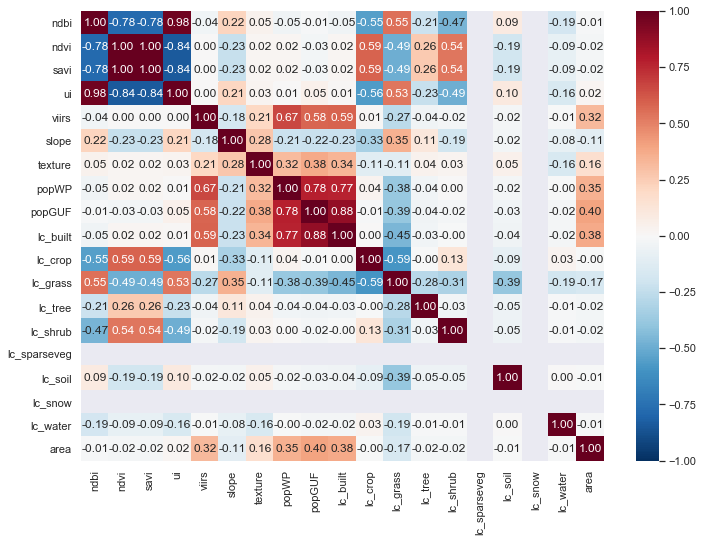

In [68]:
import seaborn as sns
from scipy import stats
#plot correlation matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(gridGeoDF.corr(), annot=True, fmt=".2f",cmap='RdBu_r', center=0, vmin=-1, vmax=1)

### test the correlation/explanatory power of the AFLC to the results

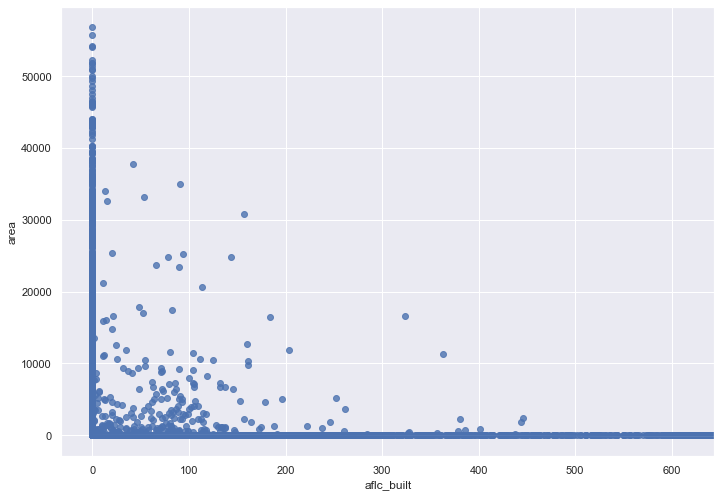

In [48]:
ax = sns.regplot(x="aflc_built", y="area", data=gridDF)

C:\ProgramData\Anaconda3\envs\gostnets0220\osm_completeness\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


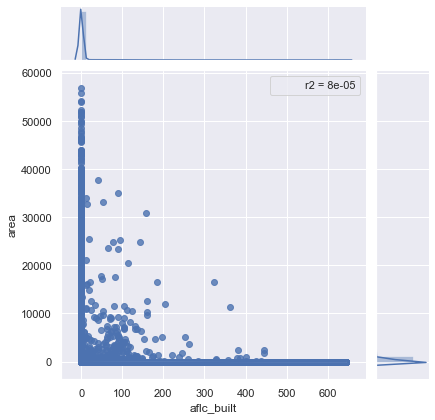

In [49]:
from scipy import stats
def r2(x,y):
    return stats.pearsonr(x,y)[0] ** 2
sns.jointplot(x="aflc_built", y="area", data=gridDF, kind="reg", stat_func=r2)

# r2 for built area = 0.